In [1]:
import datajoint as dj
import numpy as np
import time

import pandas as pd
import seaborn as sns
sns.set() #sets the asethetics parameters in what set

In [31]:
#setting the address and the username
dj.config['database.host'] = '10.28.0.34'
dj.config['database.user'] = 'celiib'
dj.config['database.password'] = 'newceliipass'
dj.config['safemode']=True
dj.config["display.limit"] = 20

schema = dj.schema('microns_pinky')
pinky = dj.create_virtual_module('pinky', 'microns_pinky')
pinky_fc = dj.create_virtual_module("pinky_fc","microns_pinky_fc")

In [ ]:
dj.ERD(schema)

In [ ]:
pinky.SkeletonCompartmentLength.describe()
print("")

In [29]:
#SkeletonCompartmentLengthWithAxon.drop()

`microns_pinky`.`__skeleton_compartment_length_with_axon` (0 tuples)


Proceed? [yes, No]:  yes


Tables dropped.  Restart kernel.


In [25]:
pinky.LabelKey.fetch()

array([( 0, 'not_labeled', 'no_color', array([0.8, 0.8, 0.8])),
       ( 1, 'label_removed', 'no_color', array([0.8, 0.8, 0.8])),
       ( 2, 'Apical', 'blue', array([0. , 0. , 0.8])),
       ( 3, 'Basal', 'yellow', array([0.8, 0.8, 0. ])),
       ( 4, 'Oblique', 'green', array([0. , 0.8, 0. ])),
       ( 5, 'Soma', 'red', array([0.8, 0. , 0. ])),
       ( 6, 'Axon-Soma', 'aqua', array([0.   , 0.8  , 0.527])),
       ( 7, 'Axon-Dendr', 'off blue', array([0.049, 0.458, 0.8  ])),
       ( 8, 'Dendrite', 'purple', array([0.2, 0. , 0.8])),
       ( 9, 'Distal', 'pink', array([0.8, 0. , 0.4])),
       (10, 'Error', 'brown', array([0.25 , 0.12 , 0.059])),
       (11, 'Unlabelable', 'tan', array([0.8  , 0.379, 0.232])),
       (12, 'Cilia', 'light purple', array([0.171, 0.147, 0.25 ])),
       (13, 'Spine Head', 'rose', array([0.8  , 0.019, 0.093])),
       (14, 'Spine', 'light pink', array([0.8  , 0.486, 0.459])),
       (15, 'Spine Neck', 'light green', array([0.309, 0.689, 0.17 ])),
      

In [32]:
@schema
class SkeletonCompartmentLengthWithAxon(dj.Computed):
    definition = """
    # Total lengths of each compartment per Skeleton.
    -> pinky.DiscretizedSkeleton
    ---
    apical_length    : float  # Length of the skeleton belonging to the apical compartment.
    basal_length     : float  # Length of the skeleton belonging to the basal compartment.
    oblique_length   : float  # Length of the skeleton belonging to the oblique compartment.
    axon_soma_length   : float  # Length of the skeleton belonging to the axon_soma compartment.
    axon_dendr_length   : float  # Length of the skeleton belonging to the axon_soma compartment.
    dendrites_length : float  # Length of the skeleton belonging to the generic dendrite compartment.
    """

    _compartment_relation = pinky.LabelKey & [dict(numeric=n) for n in [2, 3, 4, 6, 7, 8]]
    _compartment_type_map = {key_map['description'].lower().replace("-","_"): key_map['numeric'] for key_map in _compartment_relation.fetch(as_dict=True)}
    
    key_source = pinky.DiscretizedSkeleton & [dict(class_name='FilteredSkeletonMinusSoma'), dict(class_name='FilteredNeuronSkeleton')]

    def make(self, key):
        skeleton_edges = (pinky.DiscretizedSkeleton & key).fetch1('edges')
        skeleton_labels = (pinky.SkeletonLabel & key).fetch1('edge_midpoint_labels')

        insert_dict = dict(key)
        for description, numeric in self._compartment_type_map.items():
            compartment_edges = skeleton_edges[skeleton_labels==numeric]
            compartment_length = np.linalg.norm(compartment_edges[:, 0] - compartment_edges[:, 1], axis=1).sum()
            insert_dict[f'{description}_length'] = compartment_length
        
        insert_dict['dendrites_length'] = insert_dict['dendrite_length']
        del insert_dict['dendrite_length']

        self.insert1(insert_dict)

In [33]:
#(schema.jobs & "table_name='__skeleton_compartment_length_with_axon'").delete()
#schema.jobs

In [34]:
import time
start_time = time.time()
SkeletonCompartmentLengthWithAxon.populate(reserve_jobs=True)
print(f"Total time = {time.time() - start_time}")

Total time = 605.1073007583618


In [35]:
SkeletonCompartmentLengthWithAxon()

segmentation segmentation id,segment_id segment id unique within each Segmentation,class_name,maximum_edge_length,synaptic_side,apical_length Length of the skeleton belonging to the apical compartment.,basal_length Length of the skeleton belonging to the basal compartment.,oblique_length Length of the skeleton belonging to the oblique compartment.,axon_soma_length Length of the skeleton belonging to the axon_soma compartment.,axon_dendr_length Length of the skeleton belonging to the axon_soma compartment.,dendrites_length Length of the skeleton belonging to the generic dendrite compartment.
3,648518346341353574,FilteredSkeletonMinusSoma,50,postsyn,0.0,242851.0,0.0,0.0,0.0,0.0
3,648518346341353788,FilteredNeuronSkeleton,50,postsyn,0.0,0.0,0.0,0.0,0.0,24098.1
3,648518346341354313,FilteredNeuronSkeleton,50,postsyn,0.0,0.0,0.0,0.0,0.0,95712.3
3,648518346341354496,FilteredNeuronSkeleton,50,postsyn,0.0,0.0,0.0,0.0,0.0,100540.0
3,648518346341355048,FilteredNeuronSkeleton,50,postsyn,0.0,0.0,0.0,0.0,0.0,323800.0
3,648518346341355198,FilteredNeuronSkeleton,50,postsyn,0.0,0.0,0.0,0.0,0.0,29475.2
3,648518346341355736,FilteredNeuronSkeleton,50,postsyn,0.0,0.0,0.0,0.0,0.0,211692.0
3,648518346341356241,FilteredNeuronSkeleton,50,postsyn,0.0,0.0,0.0,0.0,0.0,70524.8
3,648518346341356256,FilteredNeuronSkeleton,50,postsyn,0.0,0.0,0.0,0.0,0.0,1259830.0
3,648518346341357847,FilteredNeuronSkeleton,50,postsyn,0.0,0.0,0.0,184069.0,0.0,0.0


In [ ]:
pinky.SkeletonCompartmentLength()

In [ ]:
pinky_fc.

In [ ]:
pinky.FullSkeletonContact.heading

In [ ]:
len(pinky.SkeletonContact() & "majority_label_ratio>0.9")

In [ ]:
"""
Level One analysis: Meausre how the neurons proportions match the statistics of the whole volume

Pseudo-code: 
1) Calculate for the volume the total percentage of comparments (but soma)
2) Find the percentage of synapses for the volume
3) For each axon with at least one synapse: 
- Find the compartments they synapsed on
- Weight this vector distribution as a function of length to some power
- Sum all the vectors up and see how close to 0 they can be: 
    a. try different coefficients to see if can make closer to 0 or not
    
"""



In [47]:
#1) caclulate the total volume's percentages per compartment
skeletal_compartments = pinky.SkeletonCompartmentLengthWithAxon.proj("apical_length","basal_length","oblique_length","dendrites_length",axon_length="axon_soma_length + axon_dendr_length ")
skeletal_compartments

lengths = ["apical_length","basal_length","oblique_length","dendrites_length","axon_length"]
length_data = skeletal_compartments.fetch(*lengths)
total_lengths = np.sum(length_data,axis=1)
total_lengths

array([73630845.841, 380915323.7950001, 40945953.519999996,
       78535402.28000008, 78997319.18139648], dtype=object)

In [75]:
#calculate the total percentages: 
total_percentages = total_lengths/np.sum(total_lengths)
total_percentages

1.0000000000000002

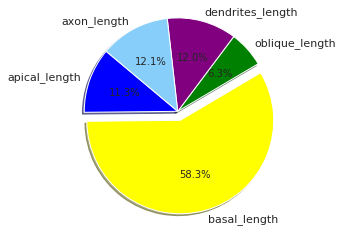

In [49]:
#2) Find axons with only one synapse
import matplotlib.pyplot as plt

# Data to plot
labels = lengths
sizes = list(total_lengths)
colors = ['blue', 'yellow', 'green', 'purple','lightskyblue']
explode = (0, .1, 0, 0,0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

In [50]:
(pinky.NeuriteTargetsRevised())

/usr/local/lib/python3.6/dist-packages/datajoint/connection.py:150: UserWarning: Mysql server has gone away. Reconnecting to the server.
  warnings.warn("Mysql server has gone away. Reconnecting to the server.")


segmentation segmentation id,segment_id segment id unique within each Segmentation,apical_num total number of apicals synapsis for neurite,apical_prop perc of total number of apicals synapsis for neurite,apical_spine_prop perc of apical synapses that are apical spine synapses,apical_spine_head_prop perc of apical synapses that are apical spine head synapses,apical_spine_neck_prop perc of apical synapses that are apical spine neck synapses,apical_shaft_prop perc of apical synapses that are apical shaft synapses,basal_num total number of basal synapsis for neurite,basal_prop perc of total number of basal synapsis for neurite,basal_spine_prop perc of basal synapses that are basal spine synapses,basal_spine_head_prop perc of basal synapses that are basal spine head synapses,basal_spine_neck_prop perc of basal synapses that are basal spine neck synapses,basal_shaft_prop perc of basal synapses that are basal shaft synapses,oblique_num total number of oblique synapsis for neurite,oblique_prop perc of total number of oblique synapsis for neurite,oblique_spine_prop perc of oblique synapses that are oblique spine synapses,oblique_spine_head_prop perc of oblique synapses that are oblique spine head synapses,oblique_spine_neck_prop perc of oblique synapses that are oblique spine neck synapses,oblique_shaft_prop perc of oblique synapses that are oblique shaft synapses,dendrite_num total number of dendrite synapsis for neurite,dendrite_prop perc of total number of dendrite synapsis for neurite,dendrite_spine_prop perc of dendrite synapses that are dendrite spine synapses,dendrite_spine_head_prop perc of dendrite synapses that are dendrite spine head synapses,dendrite_spine_neck_prop perc of dendrite synapses that are dendrite spine neck synapses,dendrite_shaft_prop perc of dendrite synapses that are dendrite shaft synapse,soma_num total number of soma synapsis for neurite,soma_prop perc of total number of soma synapsis for neurite,soma_non_spine_prop perc of total number of soma non_spine synapse,axon_num total number of axon synapsis for neurite,axon_prop perc of total number of axon synapsis for neurite,axon_non_spine_prop perc of total number of axon non_spine synapse,distal_num total number of distal synapsis for neurite,distal_prop perc of total number of distal synapsis for neurite,distal_non_spine_prop perc of total number of distal non_spine synapse,cilia_num total number of cilia synapsis for neurite,cilia_prop perc of total number of cilia synapsis for neurite,cilia_non_spine_prop perc of total number of cilia non_spine synapse,spine_num total number of spine synapsis for neurite,spine_prop perc of total number of spine synapsis for neurite,spine_head_num total number of spine head synapsis for neurite,spine_head_prop perc of total number of spine head synapsis for neurite,spine_neck_num total number of spine neck synapsis for neurite,spine_neck_prop perc of total number of spine neck synapsis for neurite,shaft_num total number of shaft synapsis for neurite,shaft_prop perc of total number of shaft synapsis for neurite,non_spine_num total number of non-spinable synapsis (aka not on apic/dendr/basal/oblique),non_spine_prop perc of total number of non-spinable synapsis (aka not on apic/dendr/basal/oblique),total total number of synapsis for neurite
3,648518346341351467,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.8,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.2,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,648518346341351503,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.75,0.25,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.25,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.25,3.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3,648518346341351508,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.5,0.0,0.166667,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.166667,0.0,0.0,0.0,0.166667,2.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.166667,0.0,0.0,5.0,0.833333,0.0,0.0,6.0
3,648518346341351509,1.0,0.125

numpy.void

In [69]:
np.array(list(total_synapse_count[0]))[1:]

array([ 22469., 100509.,  16002.,  57261.,    580.])

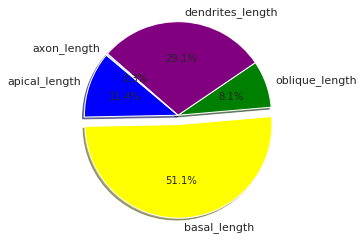

In [70]:
total_synapses = dj.U("segmentation").aggr(pinky.NeuriteTargetsRevised,apical_num="SUM(apical_num)",
                          basal_num="SUM(basal_num)",
                          oblique_num="SUM(oblique_num)",
                          dendrite_num="SUM(dendrite_num)",
                          axon_num = "SUM(axon_num)")
total_synapse_count = total_synapses.fetch()
total_synapse_count = np.array(list(total_synapse_count[0]))[1:]
#2) Find axons with only one synapse
import matplotlib.pyplot as plt

# Data to plot
labels = lengths
sizes = list(total_synapse_count)
colors = ['blue', 'yellow', 'green', 'purple','lightskyblue']
explode = (0, .1, 0, 0,0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

In [83]:
neurites_compartment = (pinky.NeuriteTargetsRevised()).proj("apical_num","basal_num","oblique_num","dendrite_num","axon_num","total")
neurite_data = neurites_compartment.fetch()

In [84]:
neurite_data
neurite_vectors = [np.array([k["apical_num"],
                             k["basal_num"],
                            k["oblique_num"],
                             k["dendrite_num"],
                            k["axon_num"],
                            ]) for k in neurite_data if k["total"] > 0]



In [ ]:
###### Adjust the axons for 20-30 for initial segment

In [88]:
print(neurite_vectors[0])
print(total_percentages)
print(neurite_vectors[0] - total_percentages*sum(neurite_vectors[0]))

[0. 4. 0. 1. 0.]
[0.11275351381790058 0.5833090837733381 0.06270198424684743
 0.12026403425127494 0.12097138391063904]
[-0.5637675690895029 1.0834545811333092 -0.31350992123423715
 0.3986798287436253 -0.6048569195531952]


In [92]:
#3) Calculate the error vectors
neurite_error_vectors = np.array([n_v - sum(n_v)*total_percentages for n_v in neurite_vectors])
neurite_error_vectors

array([[-0.5637675690895029, 1.0834545811333092, -0.31350992123423715,
        0.3986798287436253, -0.6048569195531952],
       [-0.4510140552716023, 0.6667636649066475, -0.25080793698738973,
        0.5189438629949003, -0.48388553564255615],
       [-0.4510140552716023, 0.6667636649066475, -0.25080793698738973,
        0.5189438629949003, -0.48388553564255615],
       ...,
       [-0.5637675690895029, -1.9165454188666908, 1.6864900787657628,
        1.3986798287436253, -0.6048569195531952],
       [-0.6765210829074035, 0.5001454973599713, -0.37621190548108463,
        1.2784157944923504, -0.7258283034638342],
       [-1.353042165814807, 3.0002909947199425, 0.24757618903783074,
        -0.44316841101529914, -1.4516566069276684]], dtype=object)

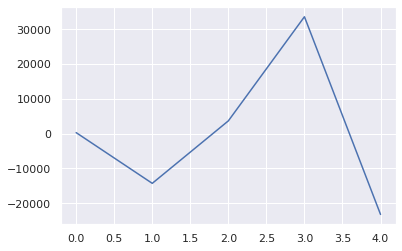

In [98]:
plt.plot(np.sum(neurite_error_vectors,axis=0))

In [ ]:
"""
Notes: 
1) Do not vector but distribution of differences
2) For receptive field can do a PCA to try and get groups of receptive field
3) Filter axons to only 6 synapses or above

"""